In [1]:
import numpy as np # array operations
import cv2 #opencv library read img operations
import os # use directory & join path
from pathlib import Path # 去掉副檔名

# data visualisation and manipulation
import matplotlib.pyplot as plt #show img and table

# from skimage.metrics import mean_squared_error
# from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity

In [2]:
def get_mean_and_std(typeStr:str, img_name:str, x:np.ndarray):
    x_mean, x_std = cv2.meanStdDev(x)
    x_mean = np.hstack(np.around(x_mean,2))
    x_std = np.hstack(np.around(x_std,2))
    
    # 印出平均與標準差
    if(typeStr == 's'):
        print("\n來源圖檔名: ", img_name)
    elif(typeStr == 't'):
        print("\n目標圖檔名: ", img_name)
    
    print("RGB_channel 平均: ", x_mean)
    print("RGB_channel 標準差: ", x_std)
    
    return x_mean, x_std

In [3]:
def color_transfer(src_rgb: np.ndarray, tar_rgb: np.ndarray, src_name:str, tar_name:str, coltra_name:str, coltra_num:int):
    
    s_mean, s_std = get_mean_and_std('s', src_name, src_rgb)
    t_mean, t_std = get_mean_and_std('t', tar_name, tar_rgb)
    
    # 輸出 source target 的 mean and std txt 檔
    output_mean_and_std_txt(coltra_name, s_mean, s_std, t_mean, t_std, coltra_num)
    
    coltra_rgb = np.ndarray(src_rgb.shape, dtype=np.uint8)
    
    for k in range(0,3):
        x = src_rgb[:,:,k]
        x = ((x-s_mean[k])*(t_std[k]/s_std[k]))+t_mean[k]
        # boundary check 超過邊界拉回在邊界上
        x = np.clip(x, 0, 255)
        coltra_rgb[:,:,k] = x
    
    # 存顏色轉換結果圖
    coltra_bgr = cv2.cvtColor(coltra_rgb,cv2.COLOR_RGB2BGR)
    cv2.imwrite('coltra/0'+ str(coltra_num)+ '_' + coltra_name + '.png', coltra_bgr)
    
    # 畫結果值方圖
    show_histogram('c', coltra_rgb, coltra_name)
    
    return coltra_rgb, s_mean, s_std, t_mean, t_std

In [4]:
def color_reverse(coltra_rgb: np.ndarray, s_mean: float, s_std: float, t_mean: float, t_std: float, src_name: str, rev_num:int):
    
    rev_rgb = np.ndarray(coltra_rgb.shape, dtype=np.uint8)
    
    for k in range(0,3):
        x = coltra_rgb[:,:,k]
        x = ((x-t_mean[k])*(s_std[k]/t_std[k]))+s_mean[k]
        # boundary check 超過邊界拉回在邊界上
        x = np.clip(x, 0, 255)
        rev_rgb[:,:,k] = x
    
    # 存顏色轉換結果圖
    rev_bgr = cv2.cvtColor(rev_rgb,cv2.COLOR_RGB2BGR)
    cv2.imwrite('revfct/0'+ str(rev_num)+ '_' + src_name + '_revfct.png', rev_bgr)
    
    return rev_rgb
    

In [5]:
def output_mean_and_std_txt(coltra_name:str, s_mean:float, s_std:float, t_mean:float, t_std:float, coltra_num:str):
    path = 'sideinfodeci/0' + str(coltra_num)+ '_' + coltra_name + '.txt'
    f = open(path, 'w')
    
    f.write(str('{:.2f}'.format(s_mean[0]))+'\n')
    f.write(str('{:.2f}'.format(s_mean[1]))+'\n')
    f.write(str('{:.2f}'.format(s_mean[2]))+'\n')
    f.write(str('{:.2f}'.format(s_std[0]))+'\n')
    f.write(str('{:.2f}'.format(s_std[1]))+'\n')
    f.write(str('{:.2f}'.format(s_std[2]))+'\n')
    
    f.write(str('{:.2f}'.format(t_mean[0]))+'\n')
    f.write(str('{:.2f}'.format(t_mean[1]))+'\n')
    f.write(str('{:.2f}'.format(t_mean[2]))+'\n')
    f.write(str('{:.2f}'.format(t_std[0]))+'\n')
    f.write(str('{:.2f}'.format(t_std[1]))+'\n')
    f.write(str('{:.2f}'.format(t_std[2]))+'\n')

    f.close()

In [6]:
def show_histogram(typeStr:str, img_rgb:np.ndarray, img_name:str):

    plt.figure(figsize=(20,10))

    # 印出圖片
    plt.subplot(231)
    plt.imshow(img_rgb)
    if(typeStr == 's'):
        plt.title("source Name : " + img_name)
    elif(typeStr == 't'):
        plt.title("target Name : " + img_name)
    elif(typeStr == 'c'):
        plt.title("coltra Name : " + img_name)

    # 繪 RGB 三通道
    color = ('r', 'g', 'b')
    for i, col in enumerate(color):

        plt.subplot(232)
        # cv2.calcHist(影像, 通道, 遮罩, 區間數量, 數值範圍)
        hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.title("RGB channel histogram")
        plt.xlabel("RBB value")
        plt.ylabel("frequent")
        plt.xlim([0, 256])

    hist_R = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
    hist_G = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
    hist_B = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])
     
    #繪個別通道值方圖
    # red channel
    plt.subplot(234)
    plt.bar(range(1,257), hist_R.ravel(), color='r')
    plt.title("red channel histogram")
    plt.xlabel("R value")
    plt.ylabel("frequent")

    # green channel
    plt.subplot(235)
    plt.bar(range(1,257), hist_G.ravel(), color='g')
    plt.title("green channel histogram")
    plt.xlabel("G value")
    plt.ylabel("frequent")

    plt.subplot(236)
    plt.bar(range(1,257), hist_B.ravel(), color='b')
    plt.title("blue channel histogram")
    plt.xlabel("B value")
    plt.ylabel("frequent")
    

In [7]:
def output_MSE_PSNR_SSIM(rev_rgb: np.ndarray, src_rgb: np.ndarray, src_name:str, img_num:int):
    
    r_mse = np.around(np.square(rev_rgb[:,:,0] - src_rgb[:,:,0]).mean(), 2)
    g_mse = np.around(np.square(rev_rgb[:,:,1] - src_rgb[:,:,1]).mean(), 2)
    b_mse = np.around(np.square(rev_rgb[:,:,2] - src_rgb[:,:,2]).mean(), 2)
    
    r_psnr = np.around(10 * np.log10(255 * 255 / r_mse),2)
    g_psnr = np.around(10 * np.log10(255 * 255 / g_mse),2)
    b_psnr = np.around(10 * np.log10(255 * 255 / b_mse),2)
    
    r_ssim = np.around(structural_similarity(rev_rgb[:,:,0], src_rgb[:,:,0], data_range=rev_rgb[:,:,0].max() - rev_rgb[:,:,0].min()),6)
    g_ssim = np.around(structural_similarity(rev_rgb[:,:,1], src_rgb[:,:,1], data_range=rev_rgb[:,:,1].max() - rev_rgb[:,:,1].min()),6)
    b_ssim = np.around(structural_similarity(rev_rgb[:,:,2], src_rgb[:,:,2], data_range=rev_rgb[:,:,2].max() - rev_rgb[:,:,2].min()),6)
    
    path = 'revfct/0' + str(img_num)+ '_' + src_name + '.txt'
    f = open(path, 'w')
    
    lines_mse = [str('{:.2f}'.format(r_mse)), str(' {:.2f}'.format(g_mse)), str(' {:.2f}'.format(b_mse))+'\n']
    f.writelines(lines_mse)
    
    lines_psnr = [str('{:.2f}'.format(r_psnr)), str(' {:.2f}'.format(g_psnr)), str(' {:.2f}'.format(b_psnr))+'\n']
    f.writelines(lines_psnr)
    
    lines_ssim = [str('{:.6f}'.format(r_ssim)), str(' {:.6f}'.format(g_ssim)), str(' {:.6f}'.format(b_ssim))+'\n']
    f.writelines(lines_ssim)
    
    f.close()
    
    print("\n")
    print("rgb_mse: ",r_mse," ", g_mse," ", b_mse)
    print("rgb_psnr: ",r_psnr," ", g_psnr," ", b_psnr)
    print("rgb_ssim: ",r_ssim," ", g_ssim," ", b_ssim)


來源圖檔名:  kodim05
RGB_channel 平均:  [91.5  81.02 67.52]
RGB_channel 標準差:  [49.07 51.4  44.72]

目標圖檔名:  kodim06
RGB_channel 平均:  [133.17 139.31 108.78]
RGB_channel 標準差:  [65.65 60.21 48.54]


rgb_mse:  7.75   7.11   1.82
rgb_psnr:  39.24   39.61   45.53
rgb_ssim:  0.976337   0.977034   0.998567

來源圖檔名:  kodim07
RGB_channel 平均:  [117.56 110.72  85.37]
RGB_channel 標準差:  [41.08 37.61 39.25]

目標圖檔名:  kodim08
RGB_channel 平均:  [127.96 121.08 116.  ]
RGB_channel 標準差:  [63.74 65.29 57.39]


rgb_mse:  3.67   4.94   1.28
rgb_psnr:  42.48   41.19   47.06
rgb_ssim:  0.98907   0.991228   0.999111

來源圖檔名:  kodim09
RGB_channel 平均:  [129.24 134.35 125.99]
RGB_channel 標準差:  [40.63 39.57 33.28]

目標圖檔名:  kodim10
RGB_channel 平均:  [115.65 124.77 118.27]
RGB_channel 標準差:  [40.37 40.91 33.89]


rgb_mse:  1.29   1.33   1.21
rgb_psnr:  47.02   46.89   47.3
rgb_ssim:  0.999901   0.999946   0.999925


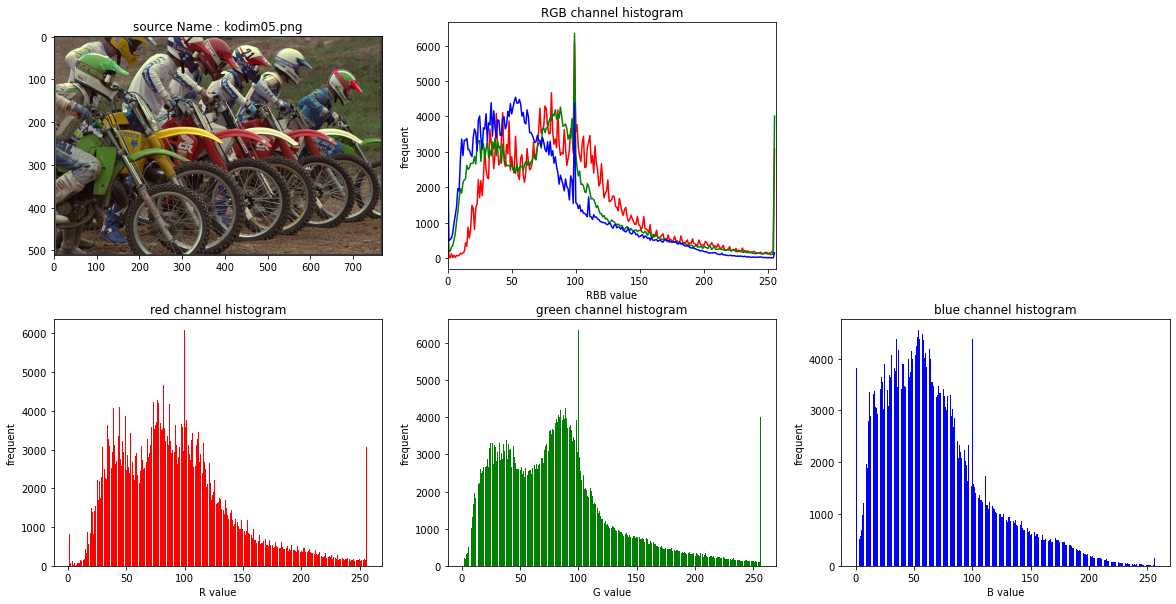

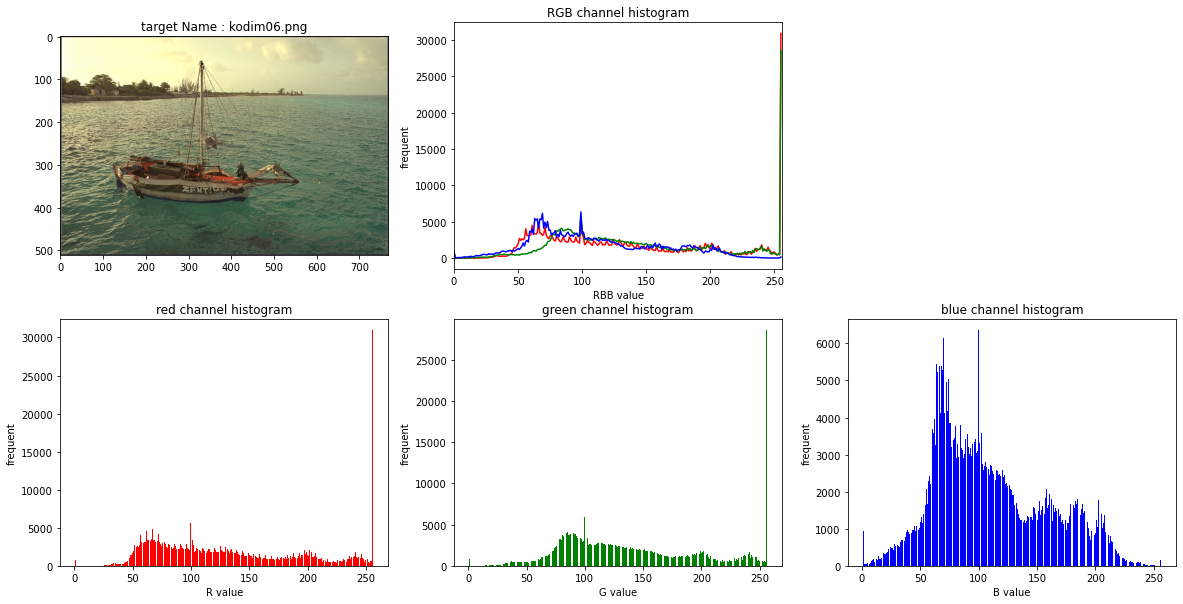

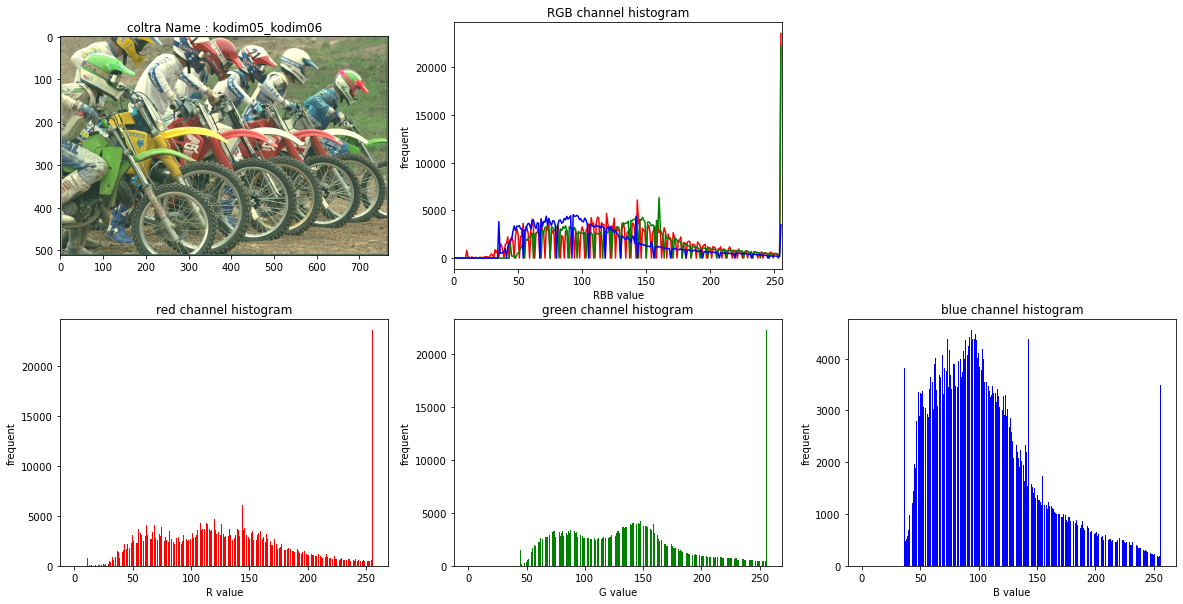

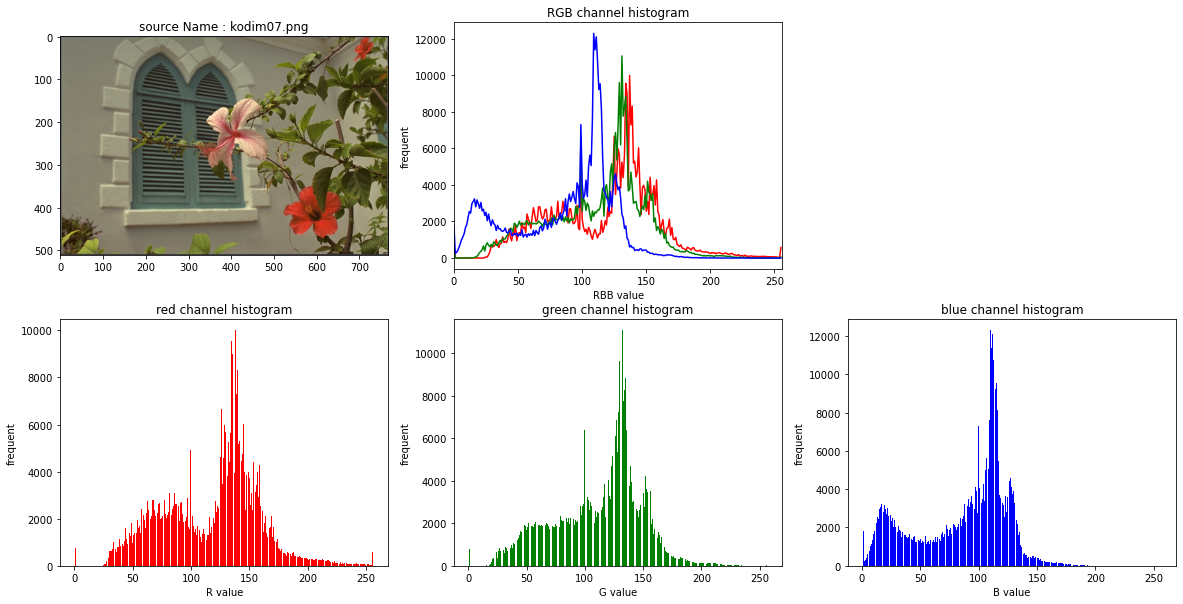

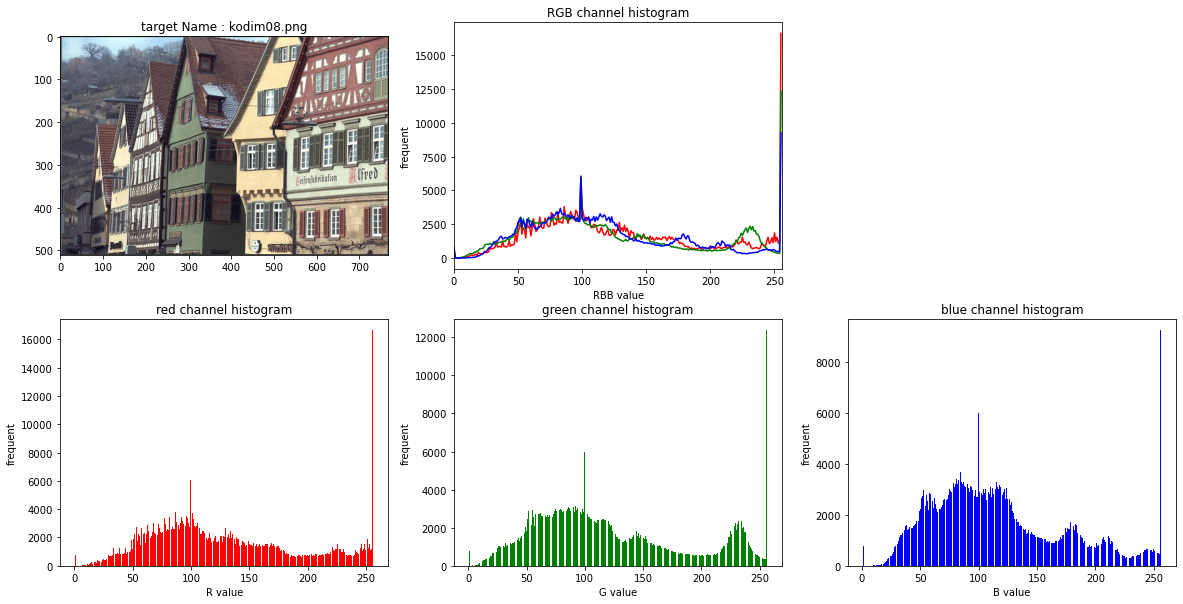

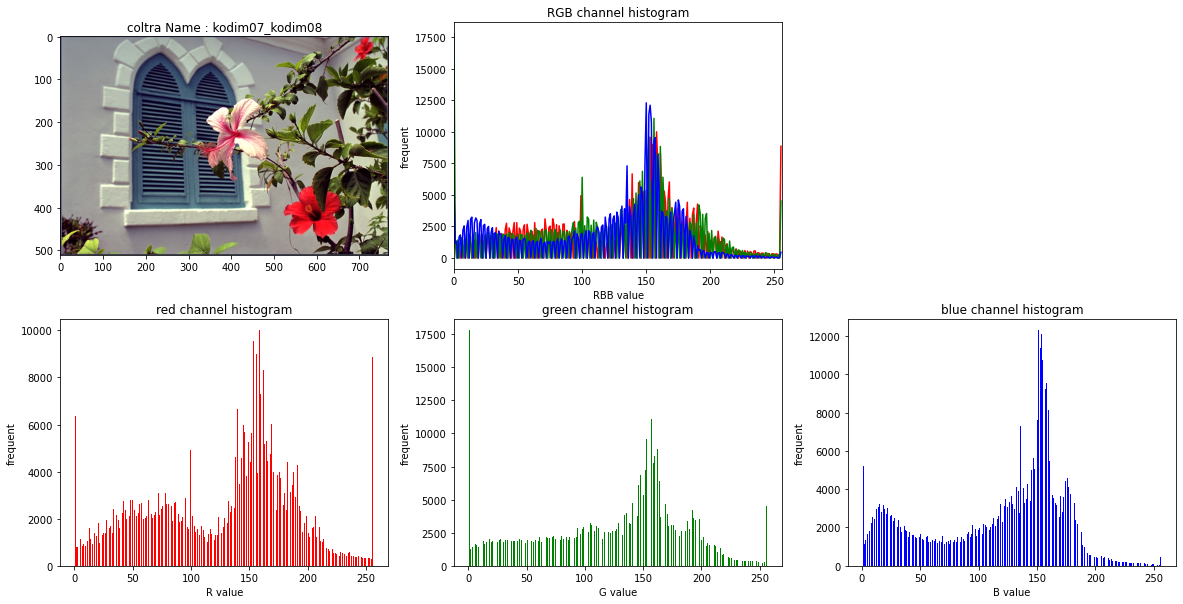

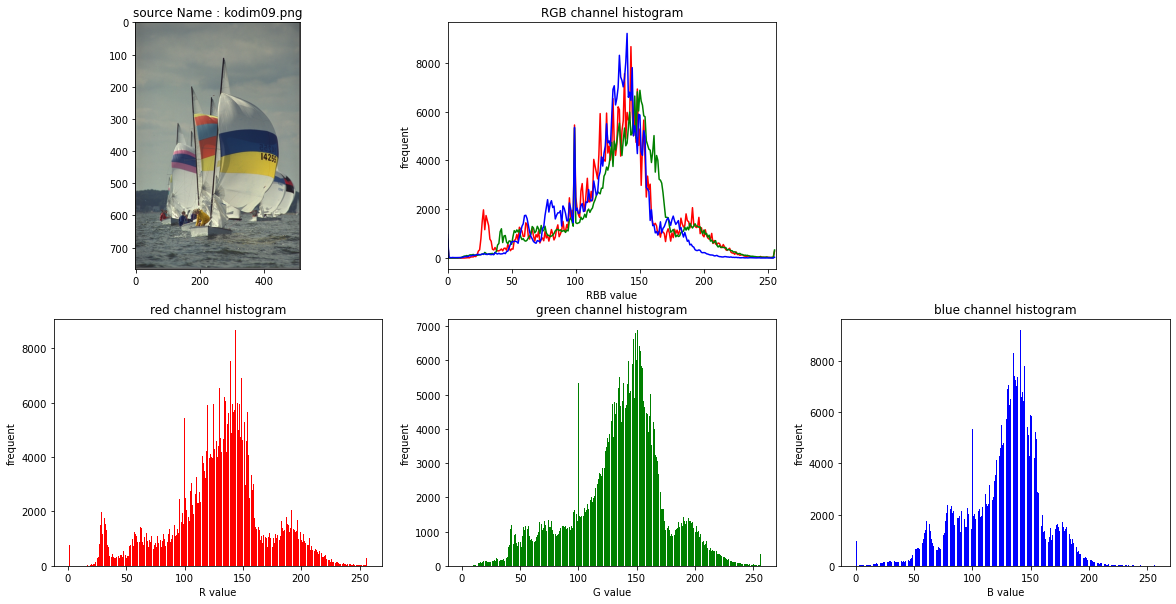

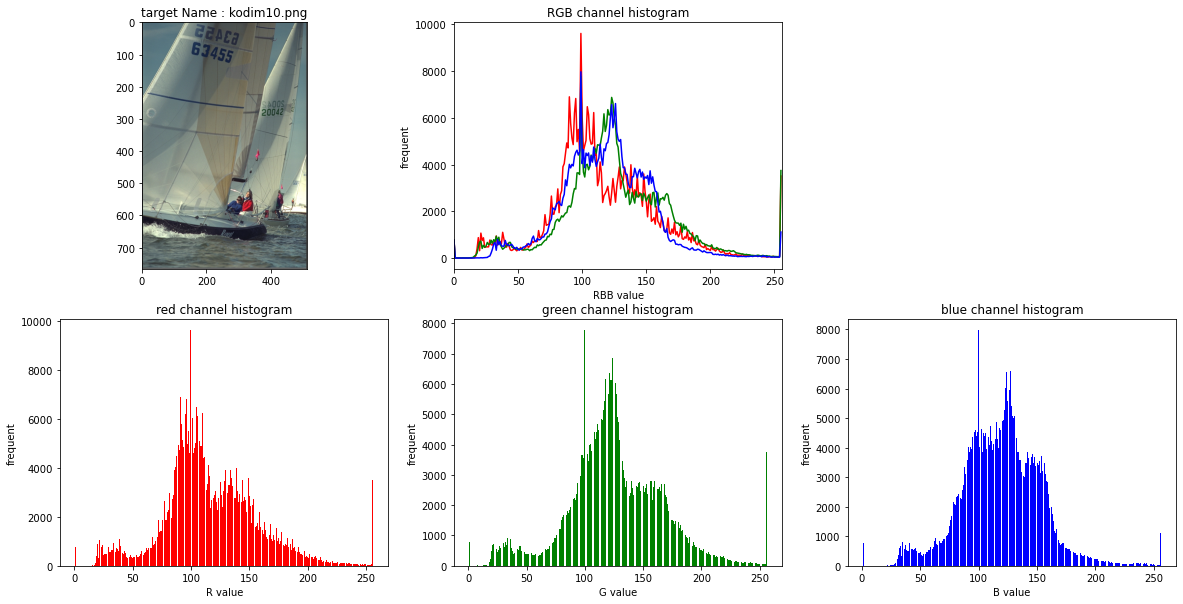

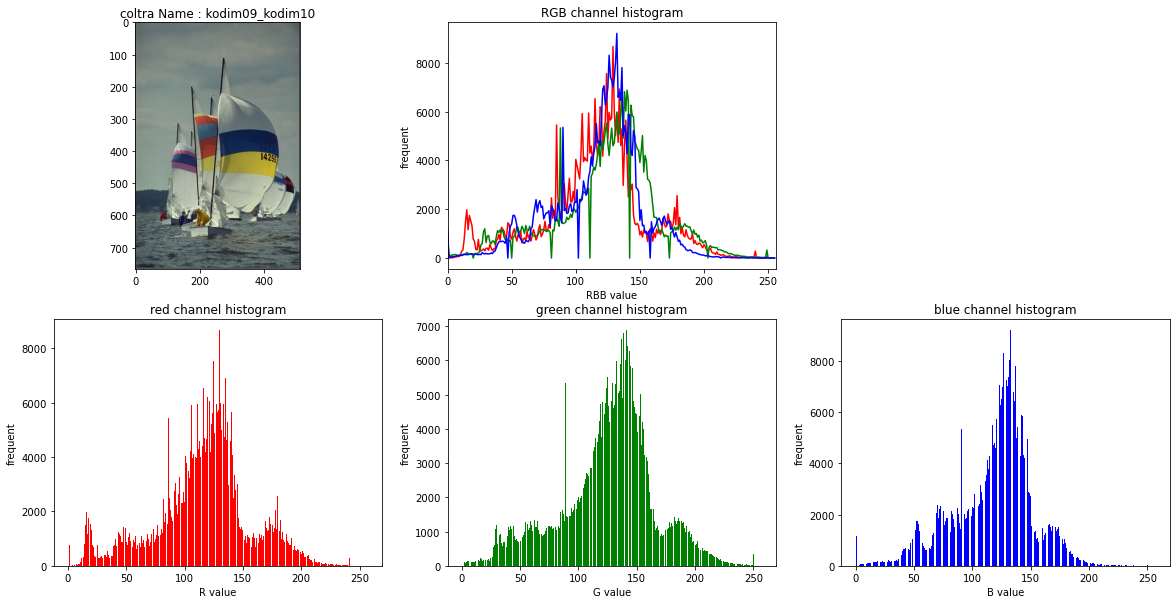

In [8]:
# 印出所有圖片
DATASRC = 'source/'
DATATRG = 'target/'

# 抓目錄下所有圖檔檔名
src_name = os.listdir(DATASRC)
tar_name = os.listdir(DATATRG)

for i in range (len(src_name)):
        
    # 圖片完整路徑
    src_path = DATASRC + src_name[i]
    tar_path = DATATRG + tar_name[i]
    
    # convert img to array 以彩色格式讀取(三維)
    src_bgr = cv2.imread(src_path ,cv2.IMREAD_COLOR)   
    tar_bgr = cv2.imread(tar_path ,cv2.IMREAD_COLOR)
    
    # 原為 BGR 轉為 RGB
    src_rgb = cv2.cvtColor(src_bgr,cv2.COLOR_BGR2RGB)
    tar_rgb = cv2.cvtColor(tar_bgr,cv2.COLOR_BGR2RGB)
    
    # 畫值方圖
    show_histogram('s', src_rgb, src_name[i])
    show_histogram('t', tar_rgb, tar_name[i])
    
    # 去掉副檔名
    src_name_temp= Path(src_path).stem 
    tar_name_temp= Path(tar_path).stem 
    coltra_name = src_name_temp +'_'+ tar_name_temp
    
    # 做色彩轉換
    coltra_rgb, s_mean, s_std, t_mean, t_std = color_transfer(src_rgb, tar_rgb, src_name_temp, tar_name_temp, coltra_name, i+1)
    
    # 做色彩反轉
    rev_rgb = color_reverse(coltra_rgb, s_mean, s_std, t_mean, t_std, src_name_temp, i+1)
    
    # 量化 逆向色彩轉移影像 與 原始來源影像之 MSE、PSNR、SSIM
    output_MSE_PSNR_SSIM(rev_rgb, src_rgb, src_name_temp, i+1)